In [41]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt


In [42]:

#using single family home prices historical dataset (zillow has a few other options as well to try including w/ condos, Xbedrooms, etc.)
sfh_prices = pd.read_csv("/Users/afrazier/Documents/personal/real_estate/data/single_family_historical.csv")
print(sfh_prices.index.size)


30468


In [43]:
#pre-processing, filter out zipcodes without significant populations
twenty_ten_census_zip_populations = pd.read_csv("data/population_by_zip_2010.csv")
zip_populations = twenty_ten_census_zip_populations.groupby('zipcode')['population'].sum().reset_index()
prices_with_pops = sfh_prices.merge(zip_populations, left_on="RegionName", right_on="zipcode")
print(prices_with_pops.index.size)
#filter to zips with atleast 25K people living there
min_population = 25000
prices_with_pops = prices_with_pops[prices_with_pops.population>min_population]
print(prices_with_pops.index.size)
sfh_prices = prices_with_pops

29906
10347


In [44]:
#melt the date,price into multiple rows instead of one wide table
date_cols = [x for x in sfh_prices.columns if sfh_prices[x].dtype=='float64']
melted_prices = pd.melt(sfh_prices, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'Metro', 'CountyName'], value_vars=date_cols)
melted_prices = melted_prices.rename(columns = {"variable": "date", "value": "price"})
melted_prices.date = pd.to_datetime(melted_prices.date)


In [45]:
# remove years/zips with null prices -> 693977/5044869 (~14%) null prices 
melted_prices = melted_prices[~(melted_prices.price.isnull())]

In [46]:
#add in the year distnace from the last date so we can perform regression on the price
max_date = melted_prices.date.max()
melted_prices['years_difference'] = (melted_prices.date-max_date)/(np.timedelta64(1, 'Y'))

#filter to only datapoints from the last 5 years
#can try other values here as it might be nice to include the 2008 crash as well
melted_prices = melted_prices[melted_prices.years_difference>-5]



In [47]:
#calculate slope, std, and number datapoints
zipcode_slopes = melted_prices.sort_values(["RegionName", "date"]).groupby("RegionName").apply(
            lambda x: linregress(x.years_difference, x['price'])[0]).round()
zipcode_slopes.name = "annual_price_slope"
zipcode_stds = melted_prices.groupby("RegionName")['price'].std().round()
zipcode_stds.name = "annual_price_std_deviation"
zipcode_datapoints = melted_prices.groupby("RegionName")['price'].size()
zipcode_datapoints.name = "total_data_points"

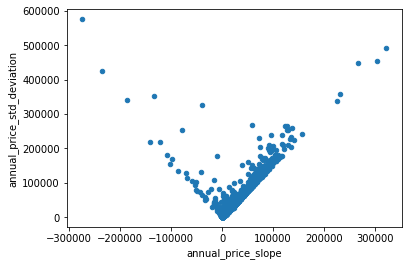

In [48]:
ten_year_slope_and_stds = pd.concat([zipcode_slopes, zipcode_stds, zipcode_datapoints], axis=1)
#lets filter to zipcodes with atleast 3 years of data?
ten_year_slope_and_stds =  ten_year_slope_and_stds[ten_year_slope_and_stds.total_data_points>=36]

ten_year_slope_and_stds.plot.scatter(x="annual_price_slope", y="annual_price_std_deviation")

In [53]:
#when using full dataset i get one dot with very high slope but significantly lower STD? 
# ten_year_slope_and_stds[ten_year_slope_and_stds.annual_price_slope>130000].sort_values("annual_price_std_deviation")
# 94129 -> San Francisco?! (presidio)

#what if filter all accounts to just the last 5 years?
ten_year_slope_and_stds['sharpe_ratios'] =  ten_year_slope_and_stds['annual_price_slope']/ten_year_slope_and_stds['annual_price_std_deviation']


#Lets Just look at zip codes with >20K increase avg. per year
growth = ten_year_slope_and_stds[ten_year_slope_and_stds.annual_price_slope>20000]
growth.sort_values('sharpe_ratios', ascending=False)[:25]

,annual_price_slope,annual_price_std_deviation,total_data_points,sharpe_ratios
RegionName,,,,
96003,22475.0,27447.0,45,0.818851
6379,21231.0,26988.0,45,0.786683
10462,37605.0,55779.0,61,0.674178
10461,36283.0,53826.0,61,0.674079
10472,36512.0,54168.0,61,0.674051
10465,31203.0,46314.0,61,0.673727
10466,28989.0,43030.0,61,0.673693
19121,30798.0,45788.0,61,0.672622
11203,33533.0,49857.0,61,0.672584


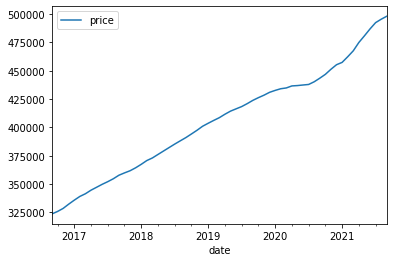

In [55]:
#interesting zipcodes 
#94129 presidio San Fran (high slope and low std from all time?) #is this because presidio wasnt in dataset during 2008 crash? 

#96003 Redding, CA 96003 top sharpe ratio for zipcodes growing more than 20K value a year
# https://www.zillow.com/homedetails/1872-Tiburon-Dr-Redding-CA-96003/15241905_zpid/ (can pay at 1600 and rent for 1800?)

#10462, 10461, 10465, 10469, 10458 -> bronx, NY?

#19121 -> philly

#11203 Brooklyn, New York

#Moab, UT (arches?!)


melted_prices[melted_prices.RegionName==84532][['date', 'price']].set_index("date").plot()
#SFH prices in SF are now at aroudn $2.6M, which seems like a lot but might be a steal given their previous trendline


In [ ]:
#requirements -> good sharpe ratio of risk to return. ideally >0.5

# forecasted annual property value increase of >20K
#have a basic linear model but might want to look into other things here


#things to add
# population is growing at decent rate
# major school, grocery store, and hospital within 10-20 miles of home
# Average salary/income shows a positive trend for this place too! 


# rental yield is strong. ie, i can make 1% of house cost in rent each year? (check vs BRRRRR book rule)
# or I can make X dollars in rent each year. 